# mlflow - autolog

## 1.환경준비

### (1) 라이브러리 Import

* 라이브러리 로딩

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

import mlflow

### (2) 데이터 불러오기

* 카시트 판매량 데이터

|	변수명	|	설명	|	구분	|
|----|----|----|
|	**Sales** 	|	 **각 지역 판매량(단위 : 1000개)**	|	**Target**	|
|	CompPrice 	|	지역별 경쟁사 판매가격(달러)	|	feature	|
|	Income 	|	가구당 평균 소득액(1000달러)	|	feature	|
|	Advertising 	|	 각 지역, 회사의 광고 예산(1000달러)	|	feature	|
|	Population 	|	 지역 인구수(단위 : 1000명)	|	feature	|
|	Price 	|	 자사 지역별 판매가격(달러)	|	feature	|
|	ShelveLoc 	|	 진열상태(범주 : Bad, Medium, Good)	|	feature	|
|	Age 	|	 지역 인구의 평균 연령	|	feature	|
|	Education 	|	 교육수준(범주 : 10~18)	|	feature	|
|	Urban 	|	 매장이 도심에 있는지 여부(범주 : Yes, No)	|	feature	|
|	US 	|	 매장이 미국에 있는지 여부(범주 : Yes, No)	|	feature	|


* 데이터 경로 : https://raw.githubusercontent.com/DA4BAM/dataset/master/Carseats.csv

In [2]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/Carseats.csv'
carseat = pd.read_csv(path)
carseat.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


## 2.전처리 및 추적 준비

### (1) 데이터 전처리

* 데이터 준비

In [3]:
target = 'Sales'
x = carseat.drop(target, axis=1)
y = carseat.loc[:, target]

* 가변수화

In [4]:
cat_cols = {'ShelveLoc':['Bad','Medium','Good']
            , 'Education':[10,11,12,13,14,15,16,17,18]
            , 'US':['No','Yes']
            , 'Urban':['No','Yes']}

for var, values in cat_cols.items():
    x[var] = pd.Categorical(x[var], categories = values)

x = pd.get_dummies(x, columns = cat_cols.keys(), drop_first = True)    

* 데이터분할

In [5]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state = 20)

* 스케일링

In [6]:
scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

### (2) Tracking 준비

#### 1) 추적설정

In [7]:
mlflow_uri = "sqlite:///mlflow.db"
mlflow.set_tracking_uri(mlflow_uri)

#### 2) 새 실험 만들기

In [8]:
exp_id = mlflow.create_experiment("exp3")
exp_id

'3'

## 3.autolog 1

### (1) sklearn 알고리즘

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

#### 1) 수동 로깅

In [10]:
with mlflow.start_run(experiment_id = exp_id):
    
    model = RandomForestRegressor()
    model.fit(x_train, y_train)
    
    pred = model.predict(x_val)
    mlflow.log_metric("mae", mean_absolute_error(y_val, pred))
        
    # best 모델 기록하기
    mlflow.sklearn.log_model(model, "model", registered_model_name="RF")

2023/04/29 20:25:16 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh()

All git commands will error until this is rectified.

This initial warning can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|none|n|0: for no warning or exception
    - warn|w|warning|1: for a printed warning
    - error|e|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet

c:\Users\hanky\anaconda3\envs\test\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully reg

#### 2) autolog

In [12]:
with mlflow.start_run(experiment_id=exp_id):
    
    # autolog!
    mlflow.sklearn.autolog()
    
    model = RandomForestRegressor()
    model.fit(x_train, y_train)
    
    mlflow.sklearn.autolog(disable = True)

2023/04/29 20:27:16 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\hanky\anaconda3\envs\test\lib\site-packages\mlflow\models\signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."


* mlflow ui에서 두 결과의 차이를 비교해 봅시다.

### (2) Grid Search 튜닝

#### 1)튜닝 일반 코드

In [13]:
# 1.튜닝 ----------------------------------------------
## 1) 하이퍼파라미터 범위 설정
params = {'n_estimators':range(20,201,20)}

## 2) GridSearchCV 모델 선언
model = GridSearchCV(RandomForestRegressor(), params, cv = 5)

## 3) 학습(튜닝)
model.fit(x_train, y_train)

# 2.튜닝 결과 데이터프레임을 csv로 저장하기
result = pd.DataFrame(model.cv_results_)
result[['param_n_estimators', 'mean_test_score','rank_test_score']].to_csv('result.csv', index = False)

,param_n_estimators,mean_test_score,rank_test_score
0,20,0.648135,10
1,40,0.674879,8
2,60,0.678249,7
3,80,0.671716,9
4,100,0.680529,5
5,120,0.682538,3
6,140,0.679503,6
7,160,0.687520,2
8,180,0.689274,1
9,200,0.681832,4


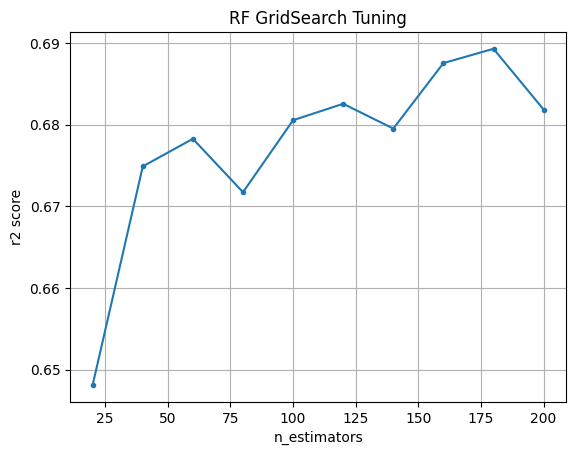

In [14]:
# 3.튜닝 결과 그래프
plt.plot('param_n_estimators', 'mean_test_score', data = result, marker = '.' )
plt.title('RF GridSearch Tuning')
plt.ylabel('r2 score')
plt.xlabel('n_estimators')
plt.grid()    
plt.show()

In [15]:
# 가장 성능이 좋았을 때 하이퍼파라미터 값
model.best_params_

{'n_estimators': 180}

In [16]:
# 가장 성능이 좋았을 때의 성능
model.best_score_

0.689273808303434

In [17]:
# 가장 성능이 좋은 모델
model.best_estimator_

RandomForestRegressor(n_estimators=180)

#### 2)autolog

2023/04/29 20:34:23 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\hanky\anaconda3\envs\test\lib\site-packages\mlflow\models\signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/04/29 20:34:37 INFO mlflow.sklearn.utils: Logging the 5 best runs, 5 runs will be omitted.
Registered model 'RF_Tuning' already exists. Cr

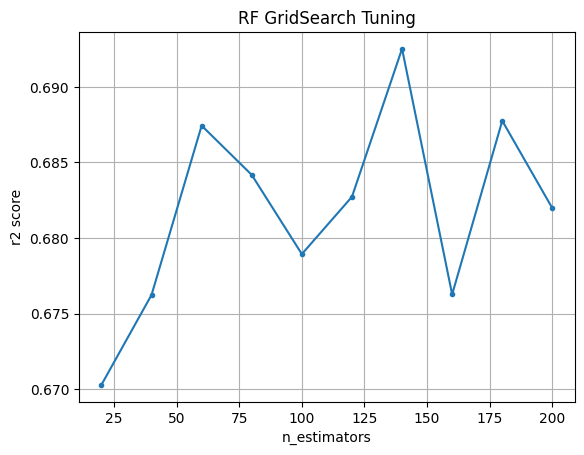

In [19]:
with mlflow.start_run(experiment_id=exp_id):
    
    mlflow.sklearn.autolog()
    
    params = {'n_estimators':range(20,201,20)}
    model = GridSearchCV(RandomForestRegressor(), params, cv = 5)
    model.fit(x_train, y_train)
    
    # 자동기록되는 부분 : 하이퍼파리미터, 성능지표, 성능평가 결과(.cv_results_)
    
    # 수동으로 등록해야 하는 부분 : 모델등록, 그래프, 추가적인 fitting 함수
    result = pd.DataFrame(model.cv_results_)
    plt.plot('param_n_estimators', 'mean_test_score', data = result, marker = '.' )
    plt.title('RF GridSearch Tuning')
    plt.ylabel('r2 score')
    plt.xlabel('n_estimators')
    plt.grid()    
    plt.savefig('RF_GridSearch_Tuning.png')
    mlflow.log_artifact("RF_GridSearch_Tuning.png")
    
    # best 모델 기록하기
    mlflow.sklearn.log_model(model.best_estimator_, "model", registered_model_name="RF_Tuning")    
       
    mlflow.sklearn.autolog(disable = True)

### (3) 실습
* exp3에 KNN regressor 튜닝 기록하기
    * mlflow.start_run 함수에 experiment_id=exp_id, run_name = 'gridsearch_tuning01' 이라고 실행 이름을 지정해 봅시다.
    * 하이퍼퍼라미터 범위 
        * n_neighbors : 1~50
        * metric : ‘euclidean’, ‘manhattan’
    * autolog
    * 추가 로깅
        * 모델 : best_estimator_ 
        * 그래프 : metric별 n_neighbors에 따른 성능 추이 그래프
* 먼저 튜닝을 시도해보고, 이상이 없으면 mlflow에 logging 하도록 합시다.
* 기록 후 mlflow 관리 페이지에서 확인해 봅시다.

2023/04/29 20:36:24 INFO mlflow.sklearn.utils: Logging the 5 best runs, 45 runs will be omitted.
Successfully registered model 'KNN_Tuning'.
2023/04/29 20:36:32 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: KNN_Tuning, version 1
Created version '1' of model 'KNN_Tuning'.


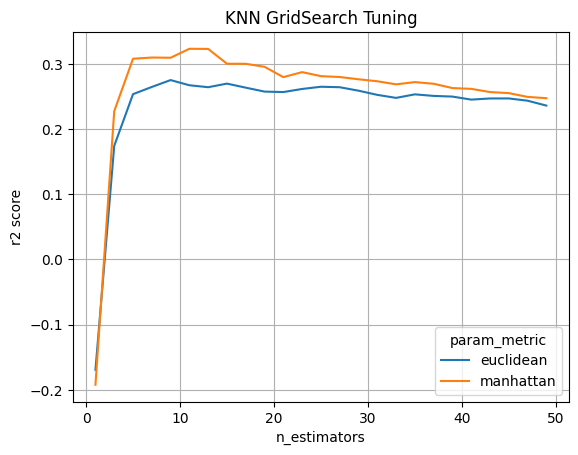

In [22]:
with mlflow.start_run(experiment_id=exp_id, run_name = 'gridsearch_tuning01'):
    
    # autolog 시작!
    mlflow.sklearn.autolog()
    
    # 튜닝 코드
    params = {'n_neighbors':range(1,51, 2), 'metric':['euclidean', 'manhattan']}
    model = GridSearchCV(KNeighborsRegressor(), params, cv = 5)
    model.fit(x_train_s, y_train)
        
    # 수동등록 : 그래프
    result = pd.DataFrame(model.cv_results_)
    sns.lineplot(x = 'param_n_neighbors', y = 'mean_test_score', data = result, hue = 'param_metric' )
    plt.title('KNN GridSearch Tuning')
    plt.ylabel('r2 score')
    plt.xlabel('n_estimators')
    plt.grid()    
    plt.savefig('KNN_GridSearch_Tuning.png')
    mlflow.log_artifact("KNN_GridSearch_Tuning.png")
    
    # 수동등록 : best 모델 기록하기
    mlflow.sklearn.log_model(model.best_estimator_, "model", registered_model_name="KNN_Tuning")    
    
    # autolog 종료
    mlflow.sklearn.autolog(disable = True)

## 4.autolog2 : Keras(Deep Learning)

In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session
from keras.callbacks import Callback
from keras.optimizers import Adam

import mlflow.keras

In [30]:
# 학습곡선 그래프
def dl_history_plot(history):
    plt.figure(figsize=(8,5))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

### (1) Keras 모델링

* input_shape 확인

In [31]:
nfeatures = x_train.shape[1] #num of columns
nfeatures

18

* 모델 구조 설계

In [32]:
model = Sequential([ Dense(1, input_shape = (nfeatures,))  ])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 19        
                                                                 
Total params: 19
Trainable params: 19
Non-trainable params: 0
_________________________________________________________________


* 컴파일 및 학습

In [ ]:
model.compile(optimizer= Adam(learning_rate = 0.1), loss='mse')
history = model.fit(x_train_s, y_train, epochs=30, validation_split=.2).history

* 학습 곡선

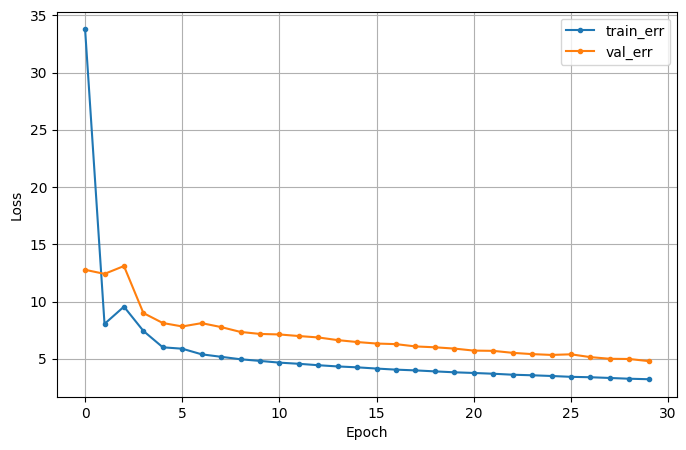

In [34]:
dl_history_plot(history)

### (2) autolog

In [35]:
with mlflow.start_run(experiment_id=exp_id):
    
    # autolog 시작
    mlflow.keras.autolog()
    
    # 모델 설계 및 컴파일
    model = Sequential([ Dense(1, input_shape = (nfeatures,))  ])
    model.compile(optimizer= Adam(learning_rate = 0.1), loss='mse')

    # 학습
    history = model.fit(x_train_s, y_train, epochs=30, validation_split=.2).history
    
    # 모델등록
    mlflow.keras.log_model(model, "keras-model",  registered_model_name="DL")
    
    # autolog 종료
    mlflow.keras.autolog(disable = True)

Epoch 1/30
8/8 [==============================] - 1s 42ms/step - loss: 33.8143 - val_loss: 11.8615
Epoch 2/30
8/8 [==============================] - 0s 12ms/step - loss: 9.0619 - val_loss: 12.2816
Epoch 3/30
8/8 [==============================] - 0s 10ms/step - loss: 9.9823 - val_loss: 12.6581
Epoch 4/30
8/8 [==============================] - 0s 10ms/step - loss: 7.3892 - val_loss: 8.3102
Epoch 5/30
8/8 [==============================] - 0s 13ms/step - loss: 5.7653 - val_loss: 7.5222
Epoch 6/30
8/8 [==============================] - 0s 10ms/step - loss: 5.8254 - val_loss: 7.3004
Epoch 7/30
8/8 [==============================] - 0s 13ms/step - loss: 5.1671 - val_loss: 7.4725
Epoch 8/30
8/8 [==============================] - 0s 9ms/step - loss: 5.0623 - val_loss: 7.5154
Epoch 9/30
8/8 [==============================] - 0s 10ms/step - loss: 4.8219 - val_loss: 7.0665
Epoch 10/30
8/8 [==============================] - 0s 14ms/step - loss: 4.7067 - val_loss: 6.7058
Epoch 11/30
8/8 [=========

2023/04/29 20:38:02 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\hanky\AppData\Local\Temp\tmpbfa1o6lf\model\data\model\assets


Successfully registered model 'DL'.
2023/04/29 20:38:16 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: DL, version 1
Created version '1' of model 'DL'.


* 딥러닝모델에서 로깅된 내용을 확인해봅시다.
* 어떤 정보를 더 로깅해야 할까요?

## 6.실습
* 실습을 해 봅시다.

### (1) 데이터 준비

* 데이터 로딩

In [36]:
path = 'https://raw.githubusercontent.com/DA4BAM/dataset/master/credit_all.csv'
data = pd.read_csv(path)
data.loc[data['Payment'] == 4, 'Payment'] = 3
data.drop(['Telephone','ForeignWorker'], axis = 1, inplace = True)
data.head()

,Creditability,AccountBalance,Duration,Payment,Purpose,CreditAmount,Employment,SexMarital,CurrentAddress,MostValuableAsset,Age,Apartment,CreditCount,Occupation,Dependents
0,1,3,24,2,0,1249,2,4,2,1,28,2,1,3,1
1,1,2,9,2,0,276,3,4,4,1,22,1,1,2,1
2,1,1,18,3,2,1049,2,2,4,2,21,1,1,3,1
3,1,1,24,3,1,6419,5,2,4,4,44,3,2,4,2
4,1,3,12,2,2,1424,5,2,4,1,55,2,1,4,1


| 칼럼명 | 설명 | | 값 의미 |  
|-----|-----|-----|-----|
|	Creditability	|	Creditability(Target)	|	향후 신용도	|	0 : Bad, 1 : Good	|
|	AccountBalance	|	Account Balance	|	은행잔고	|	1: No account, 2 : None (No balance), 3 : Some Balance	|
|	CreditDuration	|	Duration of Credit (month)	|	신청한 대출기간(월)	|	숫자	|
|	Payment	|	Payment Status of Previous Credit	|	과거 대출 납입 상태	|	0 : 연체, 1 : 기타신용, 2 : 완납, 3 : 정상 대출상환 중 |
|	Purpose	|	Purpose	|	신청한 대출목적	|	1 : New Car , 2 : Used Car , 3 : Furniture , 4 : TV , 5 : Appliances , 6 : Repair , 8 : Vacation , 9 :Retraining , 10 : Business , 0 : Other	|
|	CreditAmount	|	Credit Amount($)	|	신청한 대출금액	|		|
|	Employment	|	Length of current employment(Month)	|	현 직업 근무 기간	|	1: Unemployed,  2: <1 Year,  3: [1, 4),  4: [4, 7),  5: Above 7	|
|	SexMarital	|	Sex & Marital Status	|	성별 & 결혼상태	|	1: Male, Divorced, 2: Male, Single , 3: Male, Married/Widowed , 4: Female	|
|	CurrentAddress	|	Duration in Current address	|	현 거주지 거주기간	|	1: <1 Year , 2: [1, 4) , 3: [4, 7) , 4: Above 7	|
|	MostValuable	|	Most valuable available asset	|	가장 가치있는 자산	|	1: None , 2: Car , 3: Life Insurance , 4: Real Estate	|
|	Age	|	Age (years)	|	나이	|		|
|	AppartmentType	|	Type of apartment	|	주거환경	|	1: free apartment, 2: Rented, 3: Owned	|
|	NoCredits	|	No of Credits at this Bank	|	현재 총 대출 건수	|	1 : one, 2 : 2 ~ 3, 3 : 4 ~ 5, 4 : 6 ~	|
|	Occupation	|	Occupation	|	직업	|	1: Unemployed, unskilled, 2: Unskilled Permanent Resident, 3: Skilled, 4: Executive	|


* x, y 나누기

In [37]:
target = 'Creditability'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

* 가변수화

In [38]:
dummy_vars = [ 'Payment', 'Purpose', 'SexMarital', 'MostValuableAsset']
x = pd.get_dummies(x, columns = dummy_vars)
x.head()

,AccountBalance,Duration,CreditAmount,Employment,CurrentAddress,Age,Apartment,CreditCount,Occupation,Dependents,...,Purpose_9,Purpose_10,SexMarital_1,SexMarital_2,SexMarital_3,SexMarital_4,MostValuableAsset_1,MostValuableAsset_2,MostValuableAsset_3,MostValuableAsset_4
0,3,24,1249,2,2,28,2,1,3,1,...,False,False,False,False,False,True,True,False,False,False
1,2,9,276,3,4,22,1,1,2,1,...,False,False,False,False,False,True,True,False,False,False
2,1,18,1049,2,4,21,1,1,3,1,...,False,False,False,True,False,False,False,True,False,False
3,1,24,6419,5,4,44,3,2,4,2,...,False,False,False,True,False,False,False,False,False,True
4,3,12,1424,5,4,55,2,1,4,1,...,False,False,False,True,False,False,True,False,False,False


* train : val:test 분할

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 20, random_state = 20)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = .2, random_state = 20)

* 스케일링

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)
x_test_s = scaler.transform(x_test)

x_train_s = pd.DataFrame(x_train_s, columns = list(x_train))
x_val_s = pd.DataFrame(x_val_s, columns = list(x_train))
x_test_s = pd.DataFrame(x_test_s, columns = list(x_train))

### (2) sklearn 튜닝 모델 로깅
* KNN, SVM, Decision Tree, RandomForest 등 알고리즘으로 모델 튜닝
* mlflow.start_run(experiment_id = exp2, run_name = `모델링의 특성이 반영된 이름`)
* autolog로 로깅
* 튜닝된 모델은 수동 로깅
    * 모델 이름 : `Credit`

In [41]:
from sklearn.tree import DecisionTreeClassifier

2023/04/29 20:38:37 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\hanky\anaconda3\envs\test\lib\site-packages\mlflow\models\signature.py:137: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2023/04/29 20:38:52 INFO mlflow.sklearn.utils: Logging the 5 best runs, 14 runs will be omitted.
2023/04/29 20:39:00 WARNING mlflow.models.mode

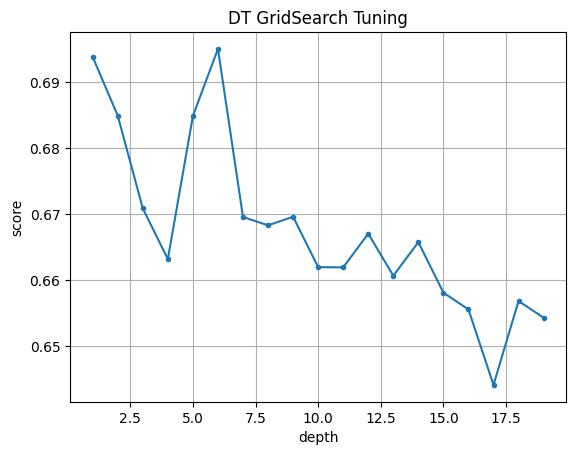

In [42]:
with mlflow.start_run(experiment_id = 2, run_name = 'DT_Tuning'):
    
    mlflow.sklearn.autolog()
    
    params = {'max_depth':range(1,20)}
    model = GridSearchCV(DecisionTreeClassifier(), params, cv = 5)
    model.fit(x_train, y_train)
    
    result = pd.DataFrame(model.cv_results_)
    plt.plot('param_max_depth', 'mean_test_score', data = result, marker = '.' )
    plt.title('DT GridSearch Tuning')
    plt.ylabel('score')
    plt.xlabel('depth')
    plt.grid()    
    plt.savefig('DT_GridSearch_Tuning.png')
    mlflow.log_artifact("DT_GridSearch_Tuning.png")
    
    # best 모델 기록하기
    mlflow.sklearn.log_model(model.best_estimator_, "model", registered_model_name="Credit")    
       
    mlflow.sklearn.autolog(disable = True)

### (3) Keras 모델 로깅
* mlflow.start_run(experiment_id = exp2, run_name = `모델링의 특성이 반영된 이름`)
* autolog로 로깅
* 튜닝된 모델은 수동 로깅
    * 모델 이름 : `Credit`

In [45]:
nfeatures = x_train.shape[1] #num of columns
nfeatures

32

In [46]:
with mlflow.start_run(experiment_id=2, run_name = 'DL'):
    
    mlflow.keras.autolog()
    
    model = Sequential([ Dense(8, input_shape = (nfeatures,), activation = 'relu'),
                         Dense(1, activation = 'sigmoid')])
    
    model.compile(optimizer= Adam(learning_rate = 0.1), loss='binary_crossentropy')

    # fit the Keras model on the dataset
    model.fit(x_train_s, y_train, epochs=30, validation_split=.2)
    mlflow.keras.log_model(model, "keras-model",  registered_model_name="Credit")
    
    mlflow.keras.autolog(disable = True)

Epoch 1/30
20/20 [==============================] - 1s 21ms/step - loss: 0.5923 - val_loss: 0.5481
Epoch 2/30
20/20 [==============================] - 0s 6ms/step - loss: 0.5302 - val_loss: 0.5441
Epoch 3/30
20/20 [==============================] - 0s 6ms/step - loss: 0.5233 - val_loss: 0.5544
Epoch 4/30
20/20 [==============================] - 0s 6ms/step - loss: 0.4847 - val_loss: 0.5444
Epoch 5/30
20/20 [==============================] - 0s 5ms/step - loss: 0.4642 - val_loss: 0.5714
Epoch 6/30
20/20 [==============================] - 0s 8ms/step - loss: 0.4452 - val_loss: 0.6823
Epoch 7/30
20/20 [==============================] - 0s 5ms/step - loss: 0.4241 - val_loss: 0.6445
Epoch 8/30
20/20 [==============================] - 0s 6ms/step - loss: 0.4164 - val_loss: 0.6762
Epoch 9/30
20/20 [==============================] - 0s 9ms/step - loss: 0.4132 - val_loss: 0.6673
Epoch 10/30
20/20 [==============================] - 0s 9ms/step - loss: 0.4115 - val_loss: 0.6095
Epoch 11/30
20/20 

2023/04/29 20:39:22 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'pandas.core.frame.DataFrame'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2023/04/29 20:39:22 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\hanky\AppData\Local\Temp\tmp9e5e3673\model\data\model\assets


2023/04/29 20:39:36 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\hanky\AppData\Local\Temp\tmp8q04cpde\model\data\model\assets


Registered model 'Credit' already exists. Creating a new version of this model...
2023/04/29 20:39:49 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Credit, version 7
Created version '7' of model 'Credit'.


### (5) test 데이터 저장

In [47]:
import joblib

joblib.dump(x_test, 'x_test.pkl')
joblib.dump(x_test_s, 'x_test_s.pkl')
joblib.dump(y_test, 'y_test.pkl')

['y_test.pkl']